# 앙상블 주식 채권 비중별

- 투자 자산 : 주식(코스피200, SPY), 채권(20년 만기 국고채, TLT)
- 투자비율 : 다음과 같은 11개의 포트폴리오(투자 전략)를 만든다(매월 말 해당 비중대로 리밸런싱).
- 매월 말 11개 전략의 수익곡선 확인
  - 주식 100%~0% 채권 0~100%
- 각 수익곡선의 최근 '6개월 모멘텀(수익률) / 최근 6개월 수익률 변동성' 상위 n 개 포트폴리오를 선정
- 동일비중으로 투자
- 결과
  - 한국 그림 2-39
      - 코스피 10.0%/-47..0%
      - 20년 만기 국고채 13.0%/-20.7%
      - 전략 15.7%/-14.5%
  - 미국 그림 2-40
      - SPY 9.7%/-50.8%
      - TLT 6.3%/-21.8%
      - 전략 10.7%/-17.5%

In [1]:
from settings import *

In [2]:
tickers = ['SPY', 'TLT']
data = yf.download(tickers)['Adj Close']
data = data.dropna()
data.info()

[*********************100%***********************]  2 of 2 completed
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4924 entries, 2002-07-30 to 2022-02-16
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   SPY     4924 non-null   float64
 1   TLT     4924 non-null   float64
dtypes: float64(2)
memory usage: 115.4 KB


In [3]:
data['2002-7']

,SPY,TLT
Date,,
2002-07-30,62.377,42.148
2002-07-31,62.528,42.671


In [4]:
s = '2002-7-31'
e = '2017-6-30'
start = '2003-2-28'

In [5]:
data = data[s:]

In [6]:
data

,SPY,TLT
Date,,
2002-07-31,62.528,42.671
2002-08-01,60.895,42.914
2002-08-02,59.530,43.353
2002-08-05,57.459,43.544
2002-08-06,59.393,43.172
...,...,...
2022-02-10,449.320,136.230
2022-02-11,440.460,138.250
2022-02-14,439.020,136.530


In [7]:
def strategy(name, data, index, bond):
    s = bt.Strategy(name,
            [
                bt.algos.RunMonthly(run_on_end_of_period=True),
                bt.algos.SelectAll(),
                bt.algos.WeighSpecified(SPY=index, TLT=bond),
                # PrintTempWeights(),
                bt.algos.Rebalance(),
            ])

    return bt.Backtest(s, data, initial_capital=100000000.0)

In [8]:
t1 = strategy("t1",   data, 1.0, 0.0)
t2 = strategy("t2",   data, 0.9, 0.1)
t3 = strategy("t3",   data, 0.8, 0.2)
t4 = strategy("t4",   data, 0.7, 0.3)
t5 = strategy("t5",   data, 0.6, 0.4)
t6 = strategy("t6",   data, 0.5, 0.5)
t7 = strategy("t7",   data, 0.4, 0.6)
t8 = strategy("t8",   data, 0.3, 0.7)
t9 = strategy("t9",   data, 0.2, 0.8)
t10 = strategy("t10", data, 0.1, 0.9)
t11 = strategy("t11", data, 0.0, 1.0)

In [151]:
class StatCalcRiskAdjustedReturn(bt.Algo):
    def __init__(self, lookback=6):
        super(StatCalcRiskAdjustedReturn, self).__init__()
        self.lookback = lookback

    def __call__(self, target):
        selected = target.temp['selected']

        prev_month = target.now# - pd.DateOffset(months=1)
        t0 = prev_month.strftime("%Y-%m")
        start = (prev_month - pd.DateOffset(months=self.lookback)).strftime("%Y-%m")

        prc = target.universe.loc[start:t0, selected].resample('M').last()

        월별수익률 = prc.pct_change().dropna()
        변동성 = 월별수익률.std()

        모멘텀 = prc.calc_total_return()
        stats = 모멘텀/변동성
        # print(f"=== {t0} {start} \n==월별수익률\n{월별수익률} \n==returns\n{모멘텀} \n==std\n{변동성}\nstats==\n{stats}\n")

        target.temp['stat'] = pd.Series(stats, index=prc.columns)

        return True

In [152]:
after_date = (datetime.strptime(start, '%Y-%m-%d') - pd.DateOffset(days=1)).strftime('%Y-%m-%d')
after_date

'2003-02-27'

In [153]:
# s = bt.Strategy("ensemble",
#         [
#             bt.algos.RunMonthly(run_on_end_of_period=True),
#             bt.algos.RunAfterDate(after_date),
#             bt.algos.SelectAll(),
#             #-------------------------------------------
#             StatCalcRiskAdjustedReturn(lookback=6),
#             bt.algos.SelectN(3),
#             bt.algos.WeighEqually(),
#             #-------------------------------------------
#             PrintTempWeights(),
#             bt.algos.Rebalance()
#         ]
# )

st = bt.Strategy("ensemble", 
        [
            bt.algos.RunMonthly(run_on_end_of_period=True),
            bt.algos.RunAfterDate(after_date),
            bt.algos.SelectAll(),
            #-------------------------------------------------------------
            # StatCalcRiskAdjustedReturn(lookback=6),
            # bt.algos.SelectN(3),
            bt.algos.SelectMomentum(n=3, lookback=pd.DateOffset(months=3)),
            bt.algos.WeighEqually(),
            #-------------------------------------------------------------
            PrintTempWeights(),
            bt.algos.Rebalance()
        ],
        [t1.strategy, t2.strategy,t3.strategy,t4.strategy,t5.strategy,t6.strategy,t7.strategy,
         t8.strategy,t9.strategy,t10.strategy,t11.strategy,]
)



In [154]:
bt_ensemble = bt.Backtest(st, data, initial_capital=100000000.0)
r = bt.run(bt_ensemble)

2003-02-28 00:00:00 ensemble t11:0.333 t10:0.333 t9:0.333 
2003-03-31 00:00:00 ensemble t11:0.333 t10:0.333 t9:0.333 
2003-04-30 00:00:00 ensemble t1:0.333 t2:0.333 t3:0.333 
2003-05-30 00:00:00 ensemble t1:0.333 t2:0.333 t3:0.333 
2003-06-30 00:00:00 ensemble t1:0.333 t2:0.333 t3:0.333 
2003-07-31 00:00:00 ensemble t1:0.333 t2:0.333 t3:0.333 
2003-08-29 00:00:00 ensemble t1:0.333 t2:0.333 t3:0.333 
2003-09-30 00:00:00 ensemble t1:0.333 t2:0.333 t3:0.333 
2003-10-31 00:00:00 ensemble t1:0.333 t2:0.333 t3:0.333 
2003-11-28 00:00:00 ensemble t1:0.333 t2:0.333 t3:0.333 
2003-12-31 00:00:00 ensemble t1:0.333 t2:0.333 t3:0.333 
2004-01-30 00:00:00 ensemble t1:0.333 t2:0.333 t3:0.333 
2004-02-27 00:00:00 ensemble t1:0.333 t2:0.333 t3:0.333 
2004-03-31 00:00:00 ensemble t11:0.333 t10:0.333 t9:0.333 
2004-04-30 00:00:00 ensemble t1:0.333 t2:0.333 t3:0.333 
2004-05-28 00:00:00 ensemble t1:0.333 t2:0.333 t3:0.333 
2004-06-30 00:00:00 ensemble t1:0.333 t2:0.333 t3:0.333 
2004-07-30 00:00:00 ensem

In [155]:
r.set_date_range(start,e)
r.display()

Stat                 ensemble
-------------------  ----------
Start                2003-02-28
End                  2017-06-30
Risk-free rate       0.00%

Total Return         441.72%
Daily Sharpe         1.03
Daily Sortino        1.73
CAGR                 12.51%
Max Drawdown         -18.21%
Calmar Ratio         0.69

MTD                  0.78%
3m                   3.13%
6m                   9.00%
YTD                  9.00%
1Y                   11.39%
3Y (ann.)            5.15%
5Y (ann.)            10.13%
10Y (ann.)           13.14%
Since Incep. (ann.)  12.51%

Daily Sharpe         1.03
Daily Sortino        1.73
Daily Mean (ann.)    12.54%
Daily Vol (ann.)     12.15%
Daily Skew           -0.09
Daily Kurt           2.17
Best Day             4.16%
Worst Day            -4.29%

Monthly Sharpe       1.12
Monthly Sortino      2.23
Monthly Mean (ann.)  12.45%
Monthly Vol (ann.)   11.11%
Monthly Skew         0.07
Monthly Kurt         3.15
Best Month           12.39%
Worst Month          -12.58%

In [156]:
r.prices.resample('M').last().to_drawdown_series().min()

ensemble   -0.150
dtype: float64

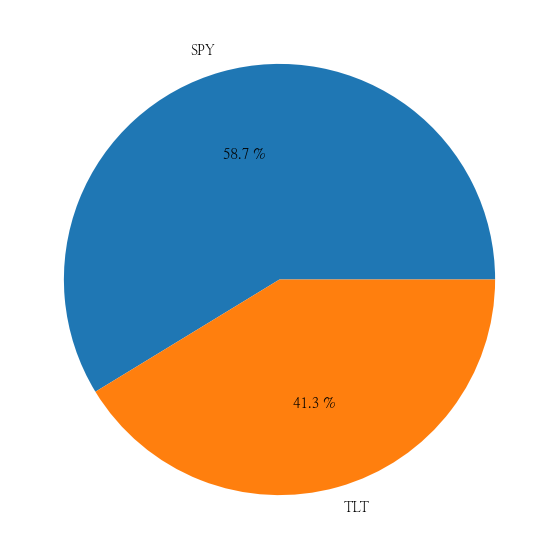

In [157]:
r.get_security_weights().sum(axis=0).plot.pie(autopct='%.1f %%', ylabel='', figsize=(7,7));

In [158]:
bt_spy = long_only_ew(data, ['SPY'], 'SPY')
bt_tlt = long_only_ew(data, ['TLT'], 'TLT')

r_spy = bt.run(bt_spy)
r_tlt  = bt.run(bt_tlt)

2002-07-31 00:00:00
2002-07-31 00:00:00


In [159]:
st_ew = bt.Strategy("ew",
        [
            bt.algos.RunMonthly(run_on_end_of_period=True),
            bt.algos.RunAfterDate(after_date),
            bt.algos.SelectAll(),
            #-------------------------------------------
            bt.algos.WeighEqually(),
            #-------------------------------------------
            PrintTempWeights(),
            bt.algos.Rebalance()
        ]
)
bt_ew = bt.Backtest(st_ew, data, initial_capital=100000000.0)
r_ew = bt.run(bt_ew)

2003-02-28 00:00:00 ew SPY:0.500 TLT:0.500 
2003-03-31 00:00:00 ew SPY:0.500 TLT:0.500 
2003-04-30 00:00:00 ew SPY:0.500 TLT:0.500 
2003-05-30 00:00:00 ew SPY:0.500 TLT:0.500 
2003-06-30 00:00:00 ew SPY:0.500 TLT:0.500 
2003-07-31 00:00:00 ew SPY:0.500 TLT:0.500 
2003-08-29 00:00:00 ew SPY:0.500 TLT:0.500 
2003-09-30 00:00:00 ew SPY:0.500 TLT:0.500 
2003-10-31 00:00:00 ew SPY:0.500 TLT:0.500 
2003-11-28 00:00:00 ew SPY:0.500 TLT:0.500 
2003-12-31 00:00:00 ew SPY:0.500 TLT:0.500 
2004-01-30 00:00:00 ew SPY:0.500 TLT:0.500 
2004-02-27 00:00:00 ew SPY:0.500 TLT:0.500 
2004-03-31 00:00:00 ew SPY:0.500 TLT:0.500 
2004-04-30 00:00:00 ew SPY:0.500 TLT:0.500 
2004-05-28 00:00:00 ew SPY:0.500 TLT:0.500 
2004-06-30 00:00:00 ew SPY:0.500 TLT:0.500 
2004-07-30 00:00:00 ew SPY:0.500 TLT:0.500 
2004-08-31 00:00:00 ew SPY:0.500 TLT:0.500 
2004-09-30 00:00:00 ew SPY:0.500 TLT:0.500 
2004-10-29 00:00:00 ew SPY:0.500 TLT:0.500 
2004-11-30 00:00:00 ew SPY:0.500 TLT:0.500 
2004-12-31 00:00:00 ew SPY:0.500

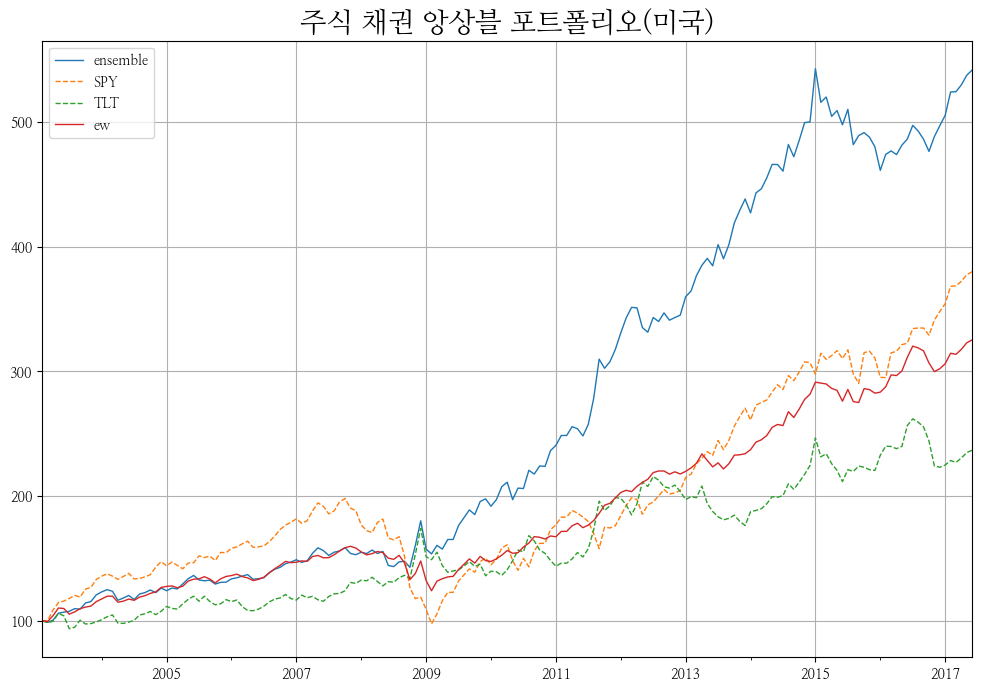

In [160]:
r_spy.set_date_range(start,e)
r_tlt.set_date_range(start,e)
r_ew.set_date_range(start,e)

ax1 = r.plot(freq='M', figsize=(12,8));
r_spy.plot(ax=ax1, freq='M', ls='--', figsize=(12,8));
r_tlt.plot(ax=ax1, freq='M', ls='--', figsize=(12,8))
r_ew.plot(ax=ax1, freq='M', ls='-', figsize=(12,8))
plt.title("주식 채권 앙상블 포트폴리오(미국)", fontsize=20);

In [161]:
r_asset = bt.run(bt_spy, bt_tlt, bt_ew, bt_ensemble)
r_asset.set_date_range(start, e)
r_asset.display()

Stat                 SPY         TLT         ew          ensemble
-------------------  ----------  ----------  ----------  ----------
Start                2003-02-28  2003-02-28  2003-02-28  2003-02-28
End                  2017-06-30  2017-06-30  2017-06-30  2017-06-30
Risk-free rate       0.00%       0.00%       0.00%       0.00%

Total Return         279.96%     136.82%     225.30%     441.72%
Daily Sharpe         0.60        0.51        0.98        1.03
Daily Sortino        0.94        0.85        1.62        1.73
CAGR                 9.76%       6.20%       8.58%       12.51%
Max Drawdown         -55.19%     -26.59%     -24.67%     -18.21%
Calmar Ratio         0.18        0.23        0.35        0.69

MTD                  0.64%       0.79%       0.71%       0.78%
3m                   2.83%       4.61%       3.72%       3.13%
6m                   9.17%       6.13%       7.65%       9.00%
YTD                  9.17%       6.13%       7.65%       9.00%
1Y                   17.77%      

In [162]:
r_asset.prices.resample('M').last().to_drawdown_series().min()

SPY        -0.508
TLT        -0.218
ew         -0.223
ensemble   -0.150
dtype: float64

           CAGR
SPY       9.759
TLT       6.199
ew        8.577
ensemble 12.509
             MDD
SPY      -55.189
TLT      -26.585
ew       -24.675
ensemble -18.205


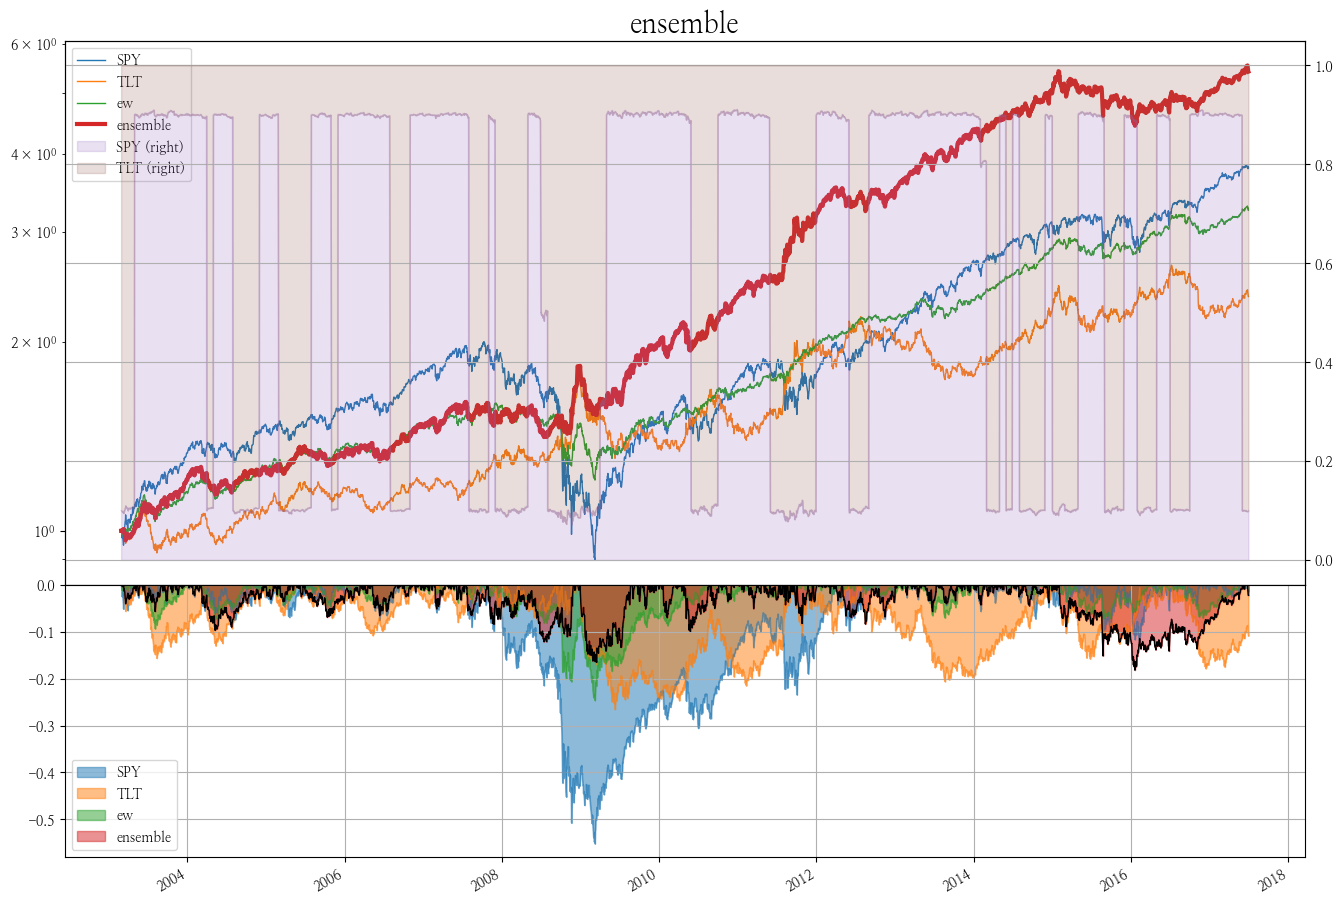

In [163]:
plot_assets(r_asset, start, e, 'ensemble')

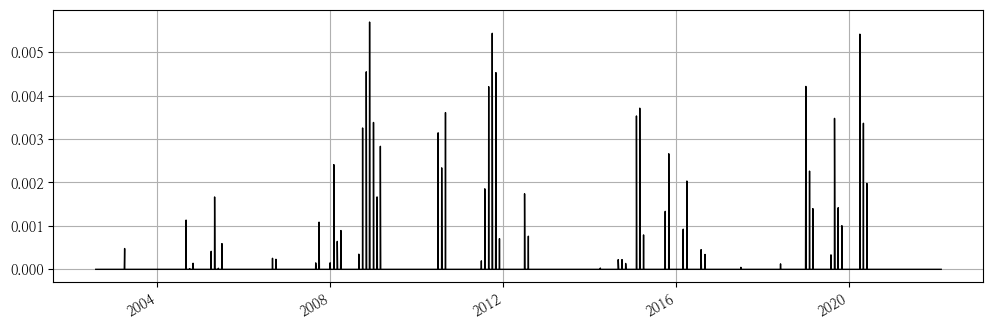

In [164]:
bt_ensemble.turnover.plot(c='black', figsize=(12, 4));

In [165]:
r.get_transactions()

price     quantity
Date       Security                     
2003-02-28 SPY       58.782    56706.000
           TLT       47.992   694565.000
2003-03-31 SPY       58.908     -804.000
           TLT       47.337     1112.000
2003-04-30 SPY       63.892   -55902.000
...                     ...          ...
2021-08-31 TLT      147.711 -2189665.000
2021-11-30 SPY      453.965    72965.000
           TLT      151.025  2193263.000
2021-12-31 SPY      474.960   -72965.000
           TLT      147.984 -2193263.000

[228 rows x 2 columns]